In [181]:
import os.path
import time
from typing import Callable, Mapping, Dict, List
import logging
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score , fbeta_score
import math
import tqdm
import numpy as np
import itertools
import pickle
import os
import pygad
import numexpr
from collections import OrderedDict

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

plt.rcParams['figure.figsize'] = [15, 10]

#a = pd.read_html("https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average")


### Kaggle dataset

In [2]:
test = pd.read_csv("historical_stock_prices.csv",usecols=[0,1,2,6,7],index_col=[0])

In [3]:
test['date'] = pd.to_datetime(test['date'])

poiščemo sumacijo volumna in glej po njem

In [4]:
valid_stonk = test.loc[test["date"]<"1.1.2000"].groupby("ticker").sum().index

c = test.groupby("ticker").sum()
c = c.loc[valid_stonk].sort_values(by=["volume"],ascending=False).head(100)


In [5]:
tickerji = c.index

računanje točk obrata trenda

In [6]:
#za trenirati uporabimo prvih deset let
groupe = test.groupby("ticker")
ticker400_data = {g:groupe.get_group(g) for g in groupe.groups if g in tickerji}

def trendReversals(df,percent,prevPivot = -1,sgn=None):
    #če ni prejšnje referenčne točke postavimo na prvo točko kot referenčno
    if prevPivot == -1:
        prevPivot = 0
    #resetiramo highest in lowest na prejšno referenčno točko, highest bo zvišveal prejšno referenčno točko saj le ta
    #je registrirana ko pridemo percent število procentov sstran od prejšne referenčne točke to ne pomeni da je to najvišja točka pivota
    #le da se je zamenjal trend
    highest = lowest = prevPivot
    #iteriramo skozi podatke v podatkovni monžici
    for i in range(prevPivot,len(df.index)):
        #če je trenutna točka višja od točke shranjene v highest
        if df.iloc[i]['open'] > df.iloc[highest]['open']:
            #v primeru da je bil prejšnji trend pozitiven in je definiran zvišujemo tudi lokacijo pivota saj je le ta najvišja točka pred spremembo trenda
            if sgn is not None and sgn:
                prevPivot = i
            #posodobimo vrednost highest z novo najvišjo vrednostjo
            highest = i
        #če je trenutna točka nižja od točke shranjene v lowest
        if df.iloc[i]['open'] < df.iloc[lowest]['open']:
            #če je prejšnji trend definiran in je negativen torej je pivot točka najnižja točka prejšnjega trenda in jo vsakič updatamo ko najdemo nižjo
            if sgn is not None and not sgn:
                prevPivot = i
            #posodobimo najnižjo točko vsakič ko je trenutna točka nižja
            lowest = i
        # če je prejšnji trend nedefiniran ali negativen in je trneutna točka od prejšnjega pivota(najvišje/nižje točke trenda) oddaljena za percent
        # se je trend zamenjal in sedaj iščemo novo pivot točko
        if (sgn is None or not sgn) and  abs((df.iloc[i]['open']-df.iloc[prevPivot]["open"])/df.iloc[prevPivot]["open"]) > percent:
            sgnN = True
            break
        elif (sgn is None or sgn) and  abs((df.iloc[i]['open']-df.iloc[prevPivot]["open"])/df.iloc[prevPivot]["open"]) > percent:
            sgnN = False
            break
    if  i == len(df.index)-1:
            return [prevPivot]

    return [prevPivot] + trendReversals(df,percent,prevPivot,sgnN)



In [ ]:

def trendReversalsOpens(df,percent,prevPivot = -1,sgn=None):
    #če ni prejšnje referenčne točke postavimo na prvo točko kot referenčno
    if prevPivot == -1:
        prevPivot = 0
    #resetiramo highest in lowest na prejšno referenčno točko, highest bo zvišveal prejšno referenčno točko saj le ta
    #je registrirana ko pridemo percent število procentov sstran od prejšne referenčne točke to ne pomeni da je to najvišja točka pivota
    #le da se je zamenjal trend
    highest = lowest = prevPivot
    #iteriramo skozi podatke v podatkovni monžici
    for i in range(prevPivot,len(df.index)):
        #če je trenutna točka višja od točke shranjene v highest
        if df.iloc[i] > df.iloc[highest]:
            #v primeru da je bil prejšnji trend pozitiven in je definiran zvišujemo tudi lokacijo pivota saj je le ta najvišja točka pred spremembo trenda
            if sgn is not None and sgn:
                prevPivot = i
            #posodobimo vrednost highest z novo najvišjo vrednostjo
            highest = i
        #če je trenutna točka nižja od točke shranjene v lowest
        if df.iloc[i] < df.iloc[lowest]:
            #če je prejšnji trend definiran in je negativen torej je pivot točka najnižja točka prejšnjega trenda in jo vsakič updatamo ko najdemo nižjo
            if sgn is not None and not sgn:
                prevPivot = i
            #posodobimo najnižjo točko vsakič ko je trenutna točka nižja
            lowest = i
        # če je prejšnji trend nedefiniran ali negativen in je trneutna točka od prejšnjega pivota(najvišje/nižje točke trenda) oddaljena za percent
        # se je trend zamenjal in sedaj iščemo novo pivot točko
        if (sgn is None or not sgn) and  abs((df.iloc[i]-df.iloc[prevPivot]["open"])/df.iloc[prevPivot]["open"]) > percent:
            sgnN = True
            break
        elif (sgn is None or sgn) and  abs((df.iloc[i]-df.iloc[prevPivot]["open"])/df.iloc[prevPivot]["open"]) > percent:
            sgnN = False
            break
    if  i == len(df.index)-1:
            return [prevPivot]

    return [prevPivot] + trendReversals(df,percent,prevPivot,sgnN)

In [ ]:
pd.Series([1,2,3,4,5,6,5,6,7,8,9,7,6,5,4,3,2])

In [202]:
# rewriting trendReversal because i think i made it incorrectly
def trend_reversal_min_max(opens: pd.Series, percent: float) -> list:
    """
    Calculate trend reversal points based on percent
    :param opens: pandas series of stock open prices
    :param percent: percent of reversal to consider a point a pivot
    :return: list of pivots
    """
    min_p = max_p = opens.iloc[0]
    idx_min = idx_max = 0
    init_all = True
    pivots = []

    for idx, val in opens.items():
        # we have found a new maximum
        if init_all:
            if val >= max_p:
                max_p = val
                idx_max = idx
            if val <= min_p:
                min_p = val
                idx_min = idx
            if abs(max_p - min_p)/min_p >= percent:
                init_all = False
                # first pivot was a minimum
                if idx_min < idx_max:
                    pivots.append(idx_min)
                    max_last_added = False
                # first pivot was a maximum
                else:
                    pivots.append(idx_max)
                    max_last_added = True
        else:
            if max_last_added:
                # we have to reset max_p because a new trough has been reached
                if min_p >= val:
                    min_p = val
                    max_p = val
                    idx_min = idx
                    idx_max = idx
                # we are searching for the start of an uptrend
                if max_p <= val:
                    max_p = val
                    idx_max = idx
                # we have come percent% away from minimum so that means that is a valid minimum we reset max_p and min_p to current point and start looking for maximum
                if abs(max_p - min_p)/min_p >= percent:
                    pivots.append(idx_min)
                    max_last_added = False
                    min_p = val
                    max_p = val
                    idx_min = idx
                    idx_max = idx
            else:
                if max_p <= val:
                    min_p = val
                    max_p = val
                    idx_min = idx
                    idx_max = idx
                if min_p >= val:
                    min_p = val
                    idx_min = idx
                if abs(max_p - min_p)/min_p >= percent:
                    pivots.append(idx_max)
                    max_last_added = True
                    min_p = val
                    max_p = val
                    idx_min = idx
                    idx_max = idx
    return pivots


testiranje zigzag

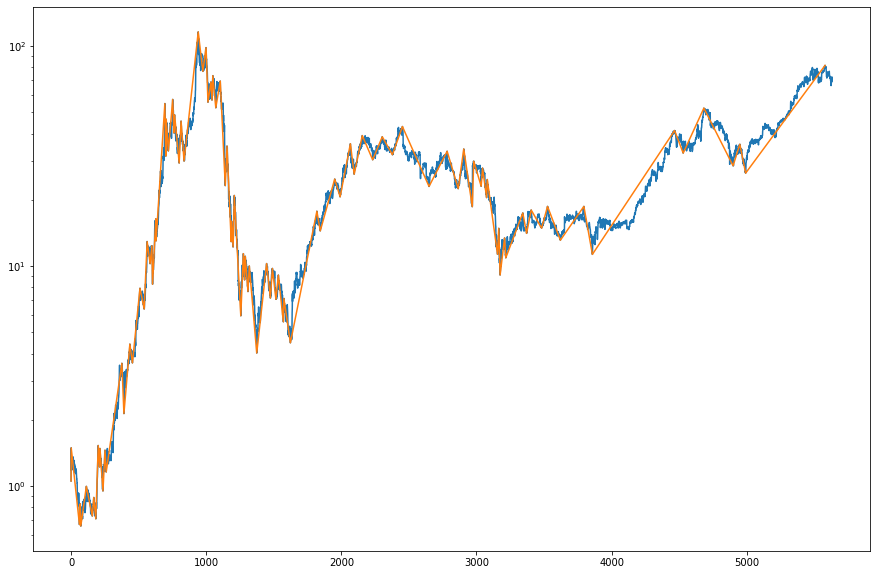

In [209]:
zigzag = trend_reversal_min_max(ticker400_data["AABA"].open,0.2)

plt.plot(range(len(ticker400_data['AABA'].index)),ticker400_data['AABA']["open"])
plt.plot(zigzag,ticker400_data['AABA']["open"].iloc[zigzag])
plt.yscale("log")
plt.show()

%return: (close-open)/open --> pozitiven return v primeru da je close visji

In [211]:
if os.path.isfile('./ticker400_data.pickle'):
    with open('ticker400_data.pickle', 'rb') as handle:
        ticker400_data = pickle.load(handle)
    with open('ticker400_trend15.pickle', 'rb') as handle:
        ticker400_trend15 = pickle.load(handle)
    with open('ticker400_tren10.pickle', 'rb') as handle:
        ticker400_trend10 = pickle.load(handle)
    with open('ticker400_trend20.pickle', 'rb') as handle:
        ticker400_trend20 = pickle.load(handle)
else:

    ticker400_trend10 = {}
    ticker400_trend15 = {}
    ticker400_trend20 = {}
    for t in ticker400_data:
        ticker400_data[t] = ticker400_data[t].sort_values(by=['date'])
        ticker400_data[t]["return"] = (ticker400_data[t]["open"] - ticker400_data[t].shift(1,fill_value=ticker400_data[t]['open'].iloc[0])["open"])/ticker400_data[t].shift(1, fill_value=ticker400_data[t]['open'].iloc[0])["open"]
        ticker400_data[t]["volume%"] =  (ticker400_data[t]["volume"] - ticker400_data[t].shift(1,fill_value=ticker400_data[t]['volume'].iloc[0])["volume"])/ticker400_data[t].shift(1, fill_value=ticker400_data[t]['volume'].iloc[0])["volume"]
        #delamo na vrsticah >n-1
        ticker400_data[t]["volume5%"] = (ticker400_data[t]["volume"] - ticker400_data[t]['volume'].rolling(5).mean())/ticker400_data[t]['volume'].rolling(5).mean()
        ticker400_data[t]["volume10%"] = (ticker400_data[t]["volume"] - ticker400_data[t]['volume'].rolling(10).mean())/ticker400_data[t]['volume'].rolling(10).mean()
        ticker400_data[t]["volume15%"] = (ticker400_data[t]["volume"] - ticker400_data[t]['volume'].rolling(15).mean())/ticker400_data[t]['volume'].rolling(15).mean()
        ticker400_data[t]["volume20%"] = (ticker400_data[t]["volume"] - ticker400_data[t]['volume'].rolling(20).mean())/ticker400_data[t]['volume'].rolling(20).mean()
        ticker400_trend15[t] = trendReversals(ticker400_data[t],0.15)
        ticker400_trend20[t] = trendReversals(ticker400_data[t],0.20)
        ticker400_trend10[t] = trendReversals(ticker400_data[t],0.10)
        ticker400_data[t].reset_index(drop=True,inplace=True)



In [212]:
if os.path.isfile('./ticker400_corrected.pickle'):
    with open('ticker400_corrected.pickle', 'rb') as handle:
        ticker400_data = pickle.load(handle)
    with open('ticker400_trend15_corrected.pickle', 'rb') as handle:
        ticker400_trend15 = pickle.load(handle)
    with open('ticker400_tren10_corrected.pickle', 'rb') as handle:
        ticker400_trend10 = pickle.load(handle)
    with open('ticker400_trend20_corrected.pickle', 'rb') as handle:
        ticker400_trend20 = pickle.load(handle)
else:

    ticker400_trend10 = {}
    ticker400_trend15 = {}
    ticker400_trend20 = {}
    for t in ticker400_data:
        ticker400_data[t] = ticker400_data[t].sort_values(by=['date'])
        ticker400_data[t]["return"] = (ticker400_data[t]["open"] - ticker400_data[t].shift(1,fill_value=ticker400_data[t]['open'].iloc[0])["open"])/ticker400_data[t].shift(1, fill_value=ticker400_data[t]['open'].iloc[0])["open"]
        ticker400_data[t]["volume%"] =  (ticker400_data[t]["volume"] - ticker400_data[t].shift(1,fill_value=ticker400_data[t]['volume'].iloc[0])["volume"])/ticker400_data[t].shift(1, fill_value=ticker400_data[t]['volume'].iloc[0])["volume"]
        #delamo na vrsticah >n-1
        ticker400_data[t]["volume5%"] = (ticker400_data[t]["volume"] - ticker400_data[t]['volume'].rolling(5).mean())/ticker400_data[t]['volume'].rolling(5).mean()
        ticker400_data[t]["volume10%"] = (ticker400_data[t]["volume"] - ticker400_data[t]['volume'].rolling(10).mean())/ticker400_data[t]['volume'].rolling(10).mean()
        ticker400_data[t]["volume15%"] = (ticker400_data[t]["volume"] - ticker400_data[t]['volume'].rolling(15).mean())/ticker400_data[t]['volume'].rolling(15).mean()
        ticker400_data[t]["volume20%"] = (ticker400_data[t]["volume"] - ticker400_data[t]['volume'].rolling(20).mean())/ticker400_data[t]['volume'].rolling(20).mean()
        ticker400_trend15[t] = trend_reversal_min_max(ticker400_data[t].open,0.15)
        ticker400_trend20[t] = trend_reversal_min_max(ticker400_data[t].open,0.20)
        ticker400_trend10[t] = trend_reversal_min_max(ticker400_data[t].open,0.10)
        ticker400_data[t].reset_index(drop=True,inplace=True)



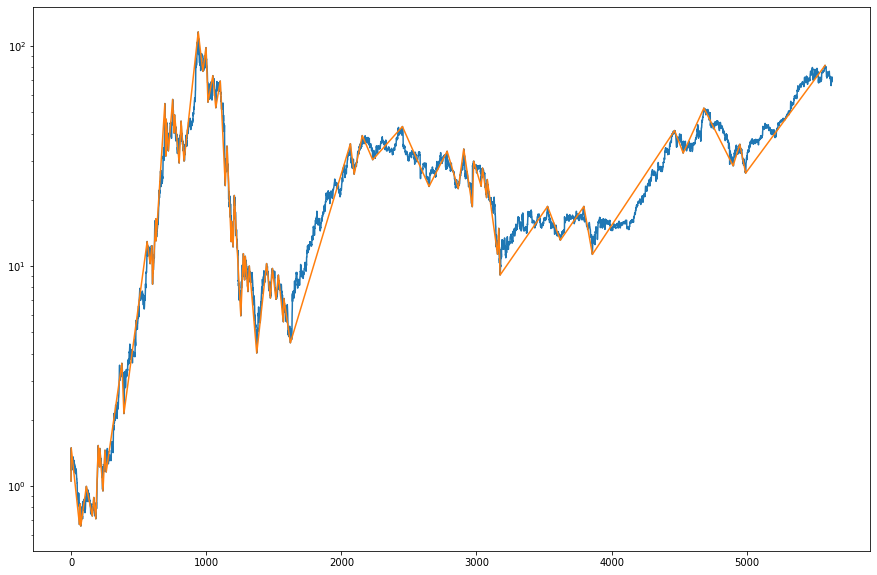

In [210]:
a = trendReversals(ticker400_data['AABA'],0.20)
plt.plot(range(len(ticker400_data['AABA'].index)),ticker400_data['AABA']["open"])
plt.plot(a,ticker400_data['AABA']["open"].iloc[a])
plt.yscale("log")
plt.show()

Damo v bool array za AUC racunat

In [213]:
ticker400_trend10B = {}
ticker400_trend15B = {}
ticker400_trend20B = {}

for t in ticker400_data:
    ticker400_trend10B[t] = pd.DataFrame(data=[False]*len(ticker400_data[t]))
    ticker400_trend10B[t].iloc[ticker400_trend10[t]] = True
    ticker400_trend15B[t] = pd.DataFrame(data=[False]*len(ticker400_data[t]))
    ticker400_trend15B[t].iloc[ticker400_trend15[t]] = True
    ticker400_trend20B[t] = pd.DataFrame(data=[False]*len(ticker400_data[t]))
    ticker400_trend20B[t].iloc[ticker400_trend20[t]] = True


In [214]:
import pickle

with open('ticker400_data_corrected.pickle', 'wb') as handle:
    pickle.dump(ticker400_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('ticker400_tren10_corrected.pickle','wb') as fp:
    pickle.dump(ticker400_trend10,fp,protocol=pickle.HIGHEST_PROTOCOL)
with open('ticker400_trend15_corrected.pickle','wb') as fp1:
    pickle.dump(ticker400_trend15,fp1,protocol=pickle.HIGHEST_PROTOCOL)
with open('ticker400_trend20_corrected.pickle','wb') as fp2:
    pickle.dump(ticker400_trend20,fp2,protocol=pickle.HIGHEST_PROTOCOL)

# Genetic algorithm

Implement a genetic algorithm that finds the optimal target, stoploss, volume,

Razdelim na test train razdelitev in poženem genetski algoritem nad tem.
opcije za split= 25% je test/50%je test in vsak mesec se doda za optimizacijo naslednga

In [215]:
splits25 = {g: train_test_split(ticker400_data[g],shuffle=False)for g in ticker400_data}
splits25_YB = {g:{10:train_test_split(ticker400_trend10B[g],shuffle=False),15:train_test_split(ticker400_trend15B[g],shuffle=False),20:train_test_split(ticker400_trend20B[g],shuffle=False)} for g in ticker400_data}
#splits50rolling = {g: train_test_split(ticker400_data[g], train_size=0.5,shuffle=False)for g in ticker400_data}
splits50rolling = {}

na podlagi teh podatkov, ki jih imam sestavimo opcijo različnega zmaika podatkov, različnega števila vštetih dni[1-7]

spremenljivke:
-doba filtrove porazdelitve za oceno odstopanja za volumen
-doba filtrove porazdelitve za oceno odstopanja za povračilo
-kje izstopiti iz trada
-kje ugotoviti če je trade napačen*


In [12]:
#splits25['AAPL'][0][3:][splits25['AAPL'][0]["return"]>0.1 and splits25['AAPL'][0]["return"]>0.1].index

In [13]:
def find_intersect_2_ordered_lists(list1,list2):
    li2=li1=0
    intersect = []
    if list1 is None or list2 is None or len(list1) == 0 or len(list2)==0 :
        return []
    while True:
        if list1[li1] == list2[li2]:
            intersect.append(list1[li1])
            li1 = li1 + 1
            li2 = li2 + 1
        elif list1[li1] < list2[li2]:
            li1 = li1 + 1
        else:
            li2 = li2 + 1
        if li1 == len(list1) or li2 == len(list2):
            return intersect

def all_true(truers):
    ret = True
    for j in truers:
        if not j:
            return False
    return True

def combine_lists(lists):
    idxs = [0 for l in lists]
    lens = [len(l) for l in lists]
    comb = []
    while True:
        if all_true([l == k for (l,k) in zip(idxs,lens)]):
            return comb
        cur = idxs.index(min(idxs))


In [14]:
def fit_params_AUC(df,dfY,tick,percent):

    def fit_me_AUC(solution, index):
        #solution = [retUP,volUP,retDW,volDW,priorRUp,priorVUp,priorRDW,priorVDW]
        if solution[0] <= -1 or solution[1] <= -1 or solution[2] <= -1 or solution[3] <= -1 or solution[4] < 0 or solution[5] < 0 or solution[6] < 0 or solution[7] < 0:
            return -10000000000
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[2]
        volFDown = solution[3]
        fit = 0
        lfRUp = list(df[tick][0][df[tick][0]["return"]>retFUp].index + math.floor(solution[4]))
        lfRDw = list(df[tick][0][df[tick][0]["return"]>retFDown].index + math.floor(solution[6]))
        lfVUp = list(df[tick][0][df[tick][0]["volume%"]>volFUp].index + math.floor(solution[5]))
        lfVDw = list(df[tick][0][df[tick][0]["volume%"]>volFDown].index + math.floor(solution[7]))



        res= pd.DataFrame(data=[False]*len(df[tick][0]))
        up = list(find_intersect_2_ordered_lists(lfVUp,lfRUp))
        cut = 0
        for k in reversed(up):
            if k < len(df[tick][0]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][0]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][0],res)
    return fit_me_AUC

In [15]:
def fit_params_AUC_lagged(df,dfY,tick,percent,n_lagged = 1):
    def fita(solution, index):
        #solution = [retUP,volUP,retDW,volDW,priorRUp,priorVUp,priorRDW,priorVDW]
        if solution[0] <= -1 or solution[1] <= -1 or solution[2] <= -1 or solution[3] <= -1 or solution[4] < 0 or solution[5] < 0 or solution[6] < 0 or solution[7] < 0:
            return -10000000000
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[2]
        volFDown = solution[3]
        fit = 0
        lfRUp = list(df[tick][0][n_lagged-1:][df[tick][0][n_lagged-1:]["return"]>retFUp].index + math.floor(solution[4]))
        lfRDw = list(df[tick][0][n_lagged-1:][df[tick][0][n_lagged-1:]["return"]>retFDown].index + math.floor(solution[6]))
        lfVUp = list(df[tick][0][n_lagged-1:][df[tick][0][n_lagged-1:][col]>volFUp].index + math.floor(solution[5]))
        lfVDw = list(df[tick][0][n_lagged-1:][df[tick][0][n_lagged-1:][col]>volFDown].index + math.floor(solution[7]))



        res= pd.DataFrame(data=[False]*len(df[tick][0][n_lagged-1:]))
        up = list(find_intersect_2_ordered_lists(lfVUp,lfRUp))
        cut = 0
        for k in reversed(up):
            if k < len(df[tick][0][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][0][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][0][n_lagged-1:],res)
    return fita

In [16]:
def fit_params_AUC_lagged_combinedOR(df,dfY,tick,percent,n_lagged = 20):
    def fita(solution, index):
        #24 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW]
        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[6]
        volFDown = solution[7]
        fit = 0
        l_UP = []
        l_DW = []
        buildingblocksUP = []
        buildingblocksDW = []
        test = df[tick][0][n_lagged-1:]
        up = test.loc[(test['return'].shift(math.floor(solution[12])) > solution[0]) |
                      (test['volume%'].shift(math.floor(solution[13])) > solution[1]) |
                       (test['volume5%'].shift(math.floor(solution[14])) > solution[2]) |
                        (test['volume10%'].shift(math.floor(solution[15])) > solution[3]) |
                         (test['volume15%'].shift(math.floor(solution[16])) > solution[4]) |
                          (test['volume20%'].shift(math.floor(solution[17])) > solution[5])
                        ].index
        down = test.loc[(test['return'].shift(math.floor(solution[18])) > solution[6]) |
        (test['volume%'].shift(math.floor(solution[19])) > solution[7]) |
        (test['volume5%'].shift(math.floor(solution[20])) > solution[8]) |
        (test['volume10%'].shift(math.floor(solution[21])) > solution[9]) |
        (test['volume15%'].shift(math.floor(solution[22])) > solution[10]) |
        (test['volume20%'].shift(math.floor(solution[23])) > solution[11])
                        ].index


        res= pd.DataFrame(data=[False]*len(df[tick][0][n_lagged-1:]))

        cut = 0
        for k in reversed(up):
            if k < len(df[tick][0][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        #down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][0][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][0][n_lagged-1:],res)
    return fita


In [17]:
def fit_params_AUC_lagged_combinedOR_test(df,dfY,tick,percent,n_lagged = 20):
    def fita(solution, index):
        #24 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW]
        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[6]
        volFDown = solution[7]
        fit = 0
        l_UP = []
        l_DW = []
        buildingblocksUP = []
        buildingblocksDW = []
        test = df[tick][1][n_lagged-1:]
        up = test.loc[(test['return'].shift(math.floor(solution[12])) > solution[0]) |
                      (test['volume%'].shift(math.floor(solution[13])) > solution[1]) |
                       (test['volume5%'].shift(math.floor(solution[14])) > solution[2]) |
                        (test['volume10%'].shift(math.floor(solution[15])) > solution[3]) |
                         (test['volume15%'].shift(math.floor(solution[16])) > solution[4]) |
                          (test['volume20%'].shift(math.floor(solution[17])) > solution[5])
                        ].index
        down = test.loc[(test['return'].shift(math.floor(solution[18])) > solution[6]) |
        (test['volume%'].shift(math.floor(solution[19])) > solution[7]) |
        (test['volume5%'].shift(math.floor(solution[20])) > solution[8]) |
        (test['volume10%'].shift(math.floor(solution[21])) > solution[9]) |
        (test['volume15%'].shift(math.floor(solution[22])) > solution[10]) |
        (test['volume20%'].shift(math.floor(solution[23])) > solution[11])
                        ].index


        res= pd.DataFrame(data=[False]*len(df[tick][1][n_lagged-1:]))

        cut = 0
        for k in reversed(up):
            if k < len(df[tick][1][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        #down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][1][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][1][n_lagged-1:],res)
    return fita

In [18]:
def fit_me10_all(solution,index):
    #solution = [retUP,volUP,retDW,volDW,priorRUp,priorVUp,priorRDW,priorVDW]
    if solution[0] <= -1 or solution[1] <= -1 or solution[2] <= -1 or solution[3] <= -1 or solution[4] < 0 or solution[5] < 0 or solution[6] < 0 or solution[7] < 0:
        return -10000000000
    #dodal bomo še kako se filtre združuje skupi z or ali and!

    retFUp = solution[0]
    volFUp = solution[1]
    retFDown = solution[2]
    volFDown = solution[3]
    fit = 0
    #print(solution.dtype)
    #nima smisla da je en pred pivotom za vrh manjši kot za dolino saj more bit return change negativen za dolino in pozitiven za vrh
    if retFUp<= retFDown:
        return -10000000000
    for tick in splits25:
        #ret filter
        #lahko še naredimo da je variable kolk prej rab se zgodit filter

        lfRUp = list(splits25[tick][0][splits25[tick][0]["return"]>retFUp].index + math.floor(solution[4]))
        lfRDw = list(splits25[tick][0][splits25[tick][0]["return"]>retFDown].index + math.floor(solution[6]))
        lfVUp = list(splits25[tick][0][splits25[tick][0]["volume%"]>volFUp].index + math.floor(solution[5]))
        lfVDw = list(splits25[tick][0][splits25[tick][0]["volume%"]>volFDown].index + math.floor(solution[7]))
        #print(len(lfRUp),len(lfRDw),len(lfVUp),len(lfVDw))
        up = set(find_intersect_2_ordered_lists(lfVUp,lfRUp))
        down = set(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        comb = list(up.union(down)).sort()


        zadetkov = len(find_intersect_2_ordered_lists(comb,ticker400_trend10[tick]))
        zgresenih = (len(comb) if comb else 0 )- zadetkov
        if comb is None:
            fit = fit -100000
        else:
            fit = fit + zadetkov - zgresenih

    return fit


In [19]:
def fit_params_AUC_lagged_combined_special(df,dfY,tick,percent,n_lagged = 20):
    def fita(solution, index):
        #24 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]
        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'
        retFUp = solution[0]
        volFUp = solution[1]
        retFDown = solution[6]
        volFDown = solution[7]
        fit = 0
        l_UP = []
        l_DW = []
        buildingblocksUP = []
        buildingblocksDW = []
        test = df[tick][1][n_lagged-1:]
        up = test.loc[(test['return'].shift(math.floor(solution[12])) > solution[0]) |
                      (test['volume%'].shift(math.floor(solution[13])) > solution[1]) |
                       (test['volume5%'].shift(math.floor(solution[14])) > solution[2]) |
                        (test['volume10%'].shift(math.floor(solution[15])) > solution[3]) |
                         (test['volume15%'].shift(math.floor(solution[16])) > solution[4]) |
                          (test['volume20%'].shift(math.floor(solution[17])) > solution[5])
                        ].index
        down = test.loc[(test['return'].shift(math.floor(solution[18])) > solution[6]) |
        (test['volume%'].shift(math.floor(solution[19])) > solution[7]) |
        (test['volume5%'].shift(math.floor(solution[20])) > solution[8]) |
        (test['volume10%'].shift(math.floor(solution[21])) > solution[9]) |
        (test['volume15%'].shift(math.floor(solution[22])) > solution[10]) |
        (test['volume20%'].shift(math.floor(solution[23])) > solution[11])
                        ].index


        res= pd.DataFrame(data=[False]*len(df[tick][1][n_lagged-1:]))

        cut = 0
        for k in reversed(up):
            if k < len(df[tick][1][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            up = up[:-cut]
        #down = list(find_intersect_2_ordered_lists(lfVDw,lfRDw))
        cut = 0
        for k in reversed(down):
            if k < len(df[tick][1][n_lagged-1:]):
                break
            else:
                cut = cut+1
        if cut > 0:
            down = down[:-cut]
        if up is not None :
            res.iloc[up] = True
        if down is not None :
            res.iloc[down] = True
        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][1][n_lagged-1:],res)
    return fita

opcija odkrivanja točk obrata

In [20]:
"""
with tqdm.tqdm(total=100) as pbar:
    gen10 = pygad.GA(num_generations=100,num_parents_mating=10,fitness_func=fit_me10_all,sol_per_pop=50,num_genes=8,init_range_low=-1)
    gen10.run()"""

'\nwith tqdm.tqdm(total=100) as pbar:\n    gen10 = pygad.GA(num_generations=100,num_parents_mating=10,fitness_func=fit_me10_all,sol_per_pop=50,num_genes=8,init_range_low=-1)\n    gen10.run()'

## Ugotovitve
- zmanjšat mormo število tickerjev ker je zadeva čist prepočasna
- statičn velik preskok ne naredi velik

In [21]:
"""num = 0
sols = {}
for tick in list(ticker400_data.keys()):
    print("Currently working on: " + tick + " " + str(num))
    num = num + 1
    #fit = fit_params_AUC(splits25,splits25_YB,tick,10)
    #print(fit)
    sols[tick] = pygad.GA(num_generations=100,num_parents_mating=10,fitness_func=fit_params_AUC(splits25,splits25_YB,tick,10),sol_per_pop=50,num_genes=8,init_range_low=-1,suppress_warnings=True,save_best_solutions=True)
    sols[tick].run()
    print(sols[tick].best_solutions)"""

'num = 0\nsols = {}\nfor tick in list(ticker400_data.keys()):\n    print("Currently working on: " + tick + " " + str(num))\n    num = num + 1\n    #fit = fit_params_AUC(splits25,splits25_YB,tick,10)\n    #print(fit)\n    sols[tick] = pygad.GA(num_generations=100,num_parents_mating=10,fitness_func=fit_params_AUC(splits25,splits25_YB,tick,10),sol_per_pop=50,num_genes=8,init_range_low=-1,suppress_warnings=True,save_best_solutions=True)\n    sols[tick].run()\n    print(sols[tick].best_solutions)'

Lagged

In [22]:
"""num = 0
sols_lagged = {k: {} for k in [1,5,10,15,20]}
for tick in list(ticker400_data.keys()):
    for lag in [1,5,10,15,20]:
        print("Currently working on: " + tick + " " + str(num))
        print("Lag: " + str(lag))
        num = num + 1
        #fit = fit_params_AUC(splits25,splits25_YB,tick,10)
        #print(fit)
        sols_lagged[lag][tick] = pygad.GA(num_generations=100,num_parents_mating=10,fitness_func=fit_params_AUC_lagged(splits25,splits25_YB,tick,10,lag),sol_per_pop=50,num_genes=8,init_range_low=-1,suppress_warnings=True,save_best_solutions=True)
        sols_lagged[lag][tick].run()
        print(sols_lagged[lag][tick].best_solutions[-1],sols_lagged[lag][tick].best_solutions_fitness[-1])"""

'num = 0\nsols_lagged = {k: {} for k in [1,5,10,15,20]}\nfor tick in list(ticker400_data.keys()):\n    for lag in [1,5,10,15,20]:\n        print("Currently working on: " + tick + " " + str(num))\n        print("Lag: " + str(lag))\n        num = num + 1\n        #fit = fit_params_AUC(splits25,splits25_YB,tick,10)\n        #print(fit)\n        sols_lagged[lag][tick] = pygad.GA(num_generations=100,num_parents_mating=10,fitness_func=fit_params_AUC_lagged(splits25,splits25_YB,tick,10,lag),sol_per_pop=50,num_genes=8,init_range_low=-1,suppress_warnings=True,save_best_solutions=True)\n        sols_lagged[lag][tick].run()\n        print(sols_lagged[lag][tick].best_solutions[-1],sols_lagged[lag][tick].best_solutions_fitness[-1])'

test solutions on test data

Združeni lagged filtri različni

In [23]:
"""num = 0
sols_filterORx2 = {k: {} for k in [10,15,20]}
for tick in list(ticker400_data.keys()):
    print("Currently working on: " + tick + " " + str(num))
    for percent in [10,15,20]:
        print("Percent: " + str(percent))
        sols_filterORx2[percent][tick] = pygad.GA(num_generations=250,num_parents_mating=10,fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,tick,percent),sol_per_pop=50,num_genes=24,init_range_low=-1,suppress_warnings=True,save_best_solutions=True,stop_criteria='saturate_7')
        sols_filterORx2[percent][tick].run()
        print(sols_filterORx2[percent][tick].best_solutions[-1],sols_filterORx2[percent][tick].best_solutions_fitness[-1])
    num = num + 1"""

'num = 0\nsols_filterORx2 = {k: {} for k in [10,15,20]}\nfor tick in list(ticker400_data.keys()):\n    print("Currently working on: " + tick + " " + str(num))\n    for percent in [10,15,20]:\n        print("Percent: " + str(percent))\n        sols_filterORx2[percent][tick] = pygad.GA(num_generations=250,num_parents_mating=10,fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,tick,percent),sol_per_pop=50,num_genes=24,init_range_low=-1,suppress_warnings=True,save_best_solutions=True,stop_criteria=\'saturate_7\')\n        sols_filterORx2[percent][tick].run()\n        print(sols_filterORx2[percent][tick].best_solutions[-1],sols_filterORx2[percent][tick].best_solutions_fitness[-1])\n    num = num + 1'

Testiranje najboljših parametrov ga

In [24]:
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
count = 0
pos = 0
if os.path.isfile('./eval1.pkl'):
    ga_evaluation = pd.read_pickle('./eval1.pkl')
    with open('pos.pickle', 'rb') as handle:
        pos = pickle.load(handle)
else:
    ga_evaluation = pd.DataFrame(columns=['St. gen', 'St. starsev','Velikost pop','Izbira starsev','K Turnir','Tip križanja','Tip muaticje','Mutacija z zamenjavo','Ustavitveni pogoj','AUC','Trajanje'])

t = c.head(1).index.values[0]
num_generations = [10,50]
num_parents_mating = [0.005,0.05,0.1,0.25,0.5]
sol_per_pop = [10,20,40,80,160,320]
#[retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW]
num_genes = 24
#!!!!!
gene_type = [np.float16 for x in range(12)]+[np.uint8 for x in range(12)]
init_range_low = -1
init_range_high = 8
parent_selection = ['sss','rws','sus','rank','random','tournament']
#if tournament
k_tournament = [0.05,0.1,0.15,0.2,0.4,0.5,0.6,0.7]
crossover_tip = ['single_point','two_points','uniform','scattered']
mutation_type=['random','swap','inversion','scramble',None]
#if mutation type random
mutation_by_replacement = [True,False]
#!!!!!
gene_space = [{'low':-1,'high':8} for x in range(12)]+[[y for y in range(20)] for j in range(12)]
save_best_solutions = True
suppress_warnings = True
stop_criteria = ['saturate_5','saturate_7','saturate_9','saturate_12','saturate_15',]

comb = list(itertools.product(num_generations,num_parents_mating,sol_per_pop,parent_selection,k_tournament,crossover_tip,mutation_type,mutation_by_replacement,stop_criteria))
print(len(comb))
print(pos)
#testiran bo za 10
for a in comb:
    if count <= pos and pos != 0 or (a[2] <= 20 and a[1] == 0.05):
        #if count % 100:
            #print("running" + str(count))
        count = count + 1
        continue
    start = datetime.datetime.now()

    if count%100 == 0:
        print(count)
    if(a[3] == 'tournament'):
        if(a[6] == 'random'):
            #print("hello")
            ins = pygad.GA(num_genes=24,gene_space=gene_space,gene_type=gene_type,init_range_low=init_range_low,init_range_high=init_range_high,save_best_solutions=True,suppress_warnings=suppress_warnings,num_generations=a[0],num_parents_mating=math.ceil(a[1]*a[2]),fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,t,10),sol_per_pop=a[2],parent_selection_type=a[3],K_tournament=math.ceil(a[4]*(math.ceil(a[1]*a[2]))),crossover_type=a[5],mutation_type=a[6],mutation_by_replacement=a[7],stop_criteria=a[8])
            ins.run()
            end = datetime.datetime.now()
            ga_evaluation = ga_evaluation.append({'St. gen':a[0], 'St. starsev':math.ceil(a[1]*a[2]),'Velikost pop': a[2],'Izbira starsev':a[3],'K Turnir':math.ceil(a[4]*(math.ceil(a[1]*a[2]))),'Tip križanja':a[5],'Tip muaticje':a[6],'Mutacija z zamenjavo':a[7],'Ustavitveni pogoj':a[8],'AUC':ins.best_solutions_fitness[-1],'Trajanje':end-start},ignore_index=True)
        else:
            if(a[7]):
                ins = pygad.GA(num_genes=24,gene_space=gene_space,gene_type=gene_type,init_range_low=init_range_low,init_range_high=init_range_high,save_best_solutions=True,suppress_warnings=suppress_warnings,num_generations=a[0],num_parents_mating=math.ceil(a[1]*a[2]),fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,t,10),sol_per_pop=a[2],parent_selection_type=a[3],K_tournament=math.ceil(a[4]*(math.ceil(a[1]*a[2]))),crossover_type=a[5],mutation_type=a[6],mutation_by_replacement=a[7],stop_criteria=a[8])
                ins.run()
                end = datetime.datetime.now()
                ga_evaluation = ga_evaluation.append({'St. gen':a[0], 'St. starsev':math.ceil(a[1]*a[2]),'Velikost pop': a[2],'Izbira starsev':a[3],'K Turnir':math.ceil(a[4]*(math.ceil(a[1]*a[2]))),'Tip križanja':a[5],'Tip muaticje':a[6],'Mutacija z zamenjavo':a[7],'Ustavitveni pogoj':a[8],'AUC':ins.best_solutions_fitness[-1],'Trajanje':end-start},ignore_index=True)
    else:
        if(a[4] == 0.05):
            if(a[6] == 'random'):
                ins = pygad.GA(num_genes=24,gene_space=gene_space,gene_type=gene_type,init_range_low=init_range_low,init_range_high=init_range_high,save_best_solutions=True,suppress_warnings=suppress_warnings,num_generations=a[0],num_parents_mating=math.ceil(a[1]*a[2]),fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,t,10),sol_per_pop=a[2],parent_selection_type=a[3],K_tournament=math.ceil(a[4]*(math.ceil(a[1]*a[2]))),crossover_type=a[5],mutation_type=a[6],mutation_by_replacement=a[7],stop_criteria=a[8])
                ins.run()
                end = datetime.datetime.now()
                ga_evaluation = ga_evaluation.append({'St. gen':a[0], 'St. starsev':math.ceil(a[1]*a[2]),'Velikost pop': a[2],'Izbira starsev':a[3],'K Turnir':math.ceil(a[4]*(math.ceil(a[1]*a[2]))),'Tip križanja':a[5],'Tip muaticje':a[6],'Mutacija z zamenjavo':a[7],'Ustavitveni pogoj':a[8],'AUC':ins.best_solutions_fitness[-1],'Trajanje':end-start},ignore_index=True)
            else:
                if(a[7]):
                    ins = pygad.GA(num_genes=24,gene_space=gene_space,gene_type=gene_type,init_range_low=init_range_low,init_range_high=init_range_high,save_best_solutions=True,suppress_warnings=suppress_warnings,num_generations=a[0],num_parents_mating=math.ceil(a[1]*a[2]),fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,t,10),sol_per_pop=a[2],parent_selection_type=a[3],K_tournament=math.ceil(a[4]*(math.ceil(a[1]*a[2]))),crossover_type=a[5],mutation_type=a[6],mutation_by_replacement=a[7],stop_criteria=a[8])
                    ins.run()
                    end = datetime.datetime.now()
                    ga_evaluation = ga_evaluation.append({'St. gen':a[0], 'St. starsev':math.ceil(a[1]*a[2]),'Velikost pop': a[2],'Izbira starsev':a[3],'K Turnir':math.ceil(a[4]*(math.ceil(a[1]*a[2]))),'Tip križanja':a[5],'Tip muaticje':a[6],'Mutacija z zamenjavo':a[7],'Ustavitveni pogoj':a[8],'AUC':ins.best_solutions_fitness[-1],'Trajanje':end-start},ignore_index=True)
    count = count+1
    gene_type = [np.float16 for x in range(12)]+[np.uint8 for x in range(12)]
    if count % 100 == 0 and ins is not None:
        pd.to_pickle(ga_evaluation,'./eval1.pkl')
        with open('pos.pickle', 'wb') as handle:
            pickle.dump(count, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(count)
pd.to_pickle(ga_evaluation,'./eval1.pkl')


576000
576000
576000


poiščemo top 10 kompozicij po AUC-ju

In [25]:
duration = 4  # seconds
freq = 440  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

0

In [26]:
ga_evaluation.sort_values(by='AUC',ascending=False).head(10)
#tip mutacije je najbolš random
#izbira starsev je sss ali rank mogoče tudi tournament
#st starsev ne rabi biti pretirano veliko za sss in rank

,St. gen,St. starsev,Velikost pop,Izbira starsev,K Turnir,Tip križanja,Tip muaticje,Mutacija z zamenjavo,Ustavitveni pogoj,AUC,Trajanje
51898,50,2,320,rank,1,uniform,random,True,saturate_12,0.615,0 days 00:01:07.169492
77931,50,80,320,tournament,56,uniform,random,True,saturate_15,0.613,0 days 00:00:55.163816
57804,50,16,320,sss,1,scattered,random,True,saturate_7,0.613,0 days 00:01:01.964698
87076,50,160,320,tournament,80,scattered,random,True,saturate_7,0.612,0 days 00:00:48.066029
58168,50,16,320,rank,1,scattered,random,False,saturate_5,0.612,0 days 00:01:03.558186
57714,50,16,320,sss,1,single_point,random,True,saturate_7,0.611,0 days 00:01:03.351108
57811,50,16,320,sss,1,scattered,random,False,saturate_12,0.611,0 days 00:01:03.281494
51932,50,2,320,rank,1,scattered,random,False,saturate_9,0.61,0 days 00:01:06.671907
77747,50,80,320,tournament,48,single_point,random,True,saturate_5,0.61,0 days 00:00:47.691477
49920,50,1,160,sss,1,single_point,random,False,saturate_5,0.609,0 days 00:00:29.041797


In [27]:
best =#{'St. gen':a[0], 'St. starsev':math.ceil(a[1]*a[2]),'Velikost pop': a[2],'Izbira starsev':a[3],'K Turnir':math.ceil(a[4]*(math.ceil(a[1]*a[2]))),'Tip križanja':a[5],'Tip muaticje':a[6],'Mutacija z zamenjavo':a[7],'Ustavitveni pogoj':a[8],'AUC':ins.best_solutions_fitness[-1],'Trajanje':end-start
res = {t:{p:{'train':None,'test':None} for p in [10,15,20]} for t in ticker400_data.keys()}
for t in list(ticker400_data):
    for percent in [10,15,20]:
        res[t][percent]['train'] = pygad.GA(num_genes=24,gene_space=gene_space,gene_type=gene_type,init_range_low=init_range_low,init_range_high=init_range_high,save_best_solutions=True,suppress_warnings=suppress_warnings,num_generations=ga_evaluation.loc["St. gen"],num_parents_mating=ga_evaluation.loc["St. starsev"],fitness_func=fit_params_AUC_lagged_combinedOR(splits25,splits25_YB,t,percent),sol_per_pop=best.loc["Velikost pop"],parent_selection_type=best.loc["Izbira starsev"],K_tournament=best.loc["K Turnir"],crossover_type=best.loc["Tip križanja"],mutation_type=best.loc["Tip muaticje"],mutation_by_replacement=best.loc["Mutacija z zamenjavo"],stop_criteria=best.loc["Ustavitveni pogoj"])
        res[t][percent]['train'].run()
        res[t][percent]['test'] = fit_params_AUC_lagged_combinedOR_test(splits25,splits25_YB,t,percent)(res[t][percent]['train'].best_solutions[-1],0)



SyntaxError: invalid syntax (712243466.py, line 1)

Grafikoni evalvacije

AUC za celotn ansambl delnic

change the metrix so it looks for values close by:
-if its within leeway% of the pivot it should count as a hit with a bit of a penalty
-if there are multiple within leeway% of the pivot only the closest should count

In [237]:
def metric_based_on_pool(pivots: list, pivots_gd: list, opens: pd.DataFrame, leeway: float = 0.03, penalty: float = 0.01) -> float:
    """
    Calculates metric based on best close pivot to ground truth pivot
    :param pivots: pivots given by model
    :param pivots_gd: ground truth pivots
    :param opens: stocks opens history
    :param leeway: percentage allowed for pivot missing the gorund truth pivot(based of model pivot)
    :param penalty: penalty for completely missing
    :return: overall score
    """
    it = 0
    firsto = True
    best_score = 0
    overall = 0

    for p in pivots:
        if pivots_gd[it] <= p < pivots_gd[it+1]:
            # do_sth
            if leeway >= abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                if firsto and best_score < 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                    best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                elif not firsto:
                    overall = overall + best_score
                    best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                    firsto = True

            elif abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]] <= leeway:
                if firsto:
                    overall = overall + best_score
                    best_score =  1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]]
                    firsto = False
                elif not firsto and best_score < 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]]:
                    best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]]
            else:
                overall = overall - penalty
        elif pivots_gd[-1] <= p < len(opens):
            # do_sth
            if abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]] <= leeway:

                if leeway >= abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                    if firsto and best_score < 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                        best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                    elif not firsto:
                        overall = overall + best_score
                        best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                        firsto = True

                elif abs(opens.iloc[pivots_gd[it+1]] - opens.iloc[p])/opens.iloc[p] <= leeway:
                    if firsto:
                        overall = overall + best_score
                        best_score =  1 - abs(opens.iloc[pivots_gd[it+1]] - opens.iloc[p])/opens.iloc[p]
                        firsto = False
                    elif not firsto and best_score < 1 - abs(opens.iloc[pivots_gd[it+1]] - opens.iloc[p])/opens.iloc[p]:
                        best_score = 1 - abs(opens.iloc[pivots_gd[it+1]] - opens.iloc[p])/opens.iloc[p]
                else:
                    overall = overall - penalty
        else:
            # fix pivots
            for it in range(it,len(pivots_gd)):
                if pivots_gd[it] <= p < pivots_gd[it+1]:
                    if leeway >= abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                        if firsto and best_score < 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]:
                            best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                        elif not firsto:
                            overall = overall + best_score
                            best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it]])/opens.iloc[pivots_gd[it]]
                            firsto = True

                    elif abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]] <= leeway:
                        if firsto:
                            overall = overall + best_score
                            best_score =  1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]]
                            firsto = False
                        elif not firsto and best_score < 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]]:
                            best_score = 1 - abs(opens.iloc[p] - opens.iloc[pivots_gd[it+1]])/opens.iloc[pivots_gd[it+1]]
                    else:
                        overall = overall - penalty
                    break
    return overall

In [28]:
def fit_params_AUC_lagged_combined_special(df,dfY,tick,percent,n_lagged = 20,sty=0,metric=roc_auc_score, beta = -1):
    def fita(solution, index):
        #47 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]

        ####TRANSLATE TO POS ARGS####
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################

        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        test = df[tick][0][n_lagged-1:]

        ############QUERY SPEED TEST##############
        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()

        u0 = ' | ' if solution[36] else ' & '
        u1 = ' | ' if solution[37] else ' & '
        u2 = ' | ' if solution[38] else ' & '
        u3 = ' | ' if solution[39] else ' & '
        u4 = ' | ' if solution[40] else ' & '

        connec = ' | ' if solution[-1] else ' & '

        d0 = ' | ' if solution[41] else ' & '
        d1 = ' | ' if solution[42] else ' & '
        d2 = ' | ' if solution[43] else ' & '
        d3 = ' | ' if solution[44] else ' & '
        d4 = ' | ' if solution[45] else ' & '
        q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
            '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
            '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
            '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
            '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
            '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
            connec +
            '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
            '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
            '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
            '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
            '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
            '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')

        up = test.query(q).index
        res = np.array([False]*len(test))
        res[up] =True

        if beta != -1:
            return metric(dfY[tick][percent][0][n_lagged-1:],res,beta=beta)
        return metric(dfY[tick][percent][0][n_lagged-1:],res)
    return fita

In [29]:
def fit_params_AUC_lagged_combined_special_test(df,dfY,tick,percent,n_lagged = 20,sty=0,metric=roc_auc_score, beta=-1):
    def fita(solution, index):
        #47 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]

        ####TRANSLATE TO POS ARGS####
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################

        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]


        test = df[tick][1][n_lagged-1:]

        ############QUERY SPEED TEST##############
        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()

        u0 = ' | ' if solution[36] else ' & '
        u1 = ' | ' if solution[37] else ' & '
        u2 = ' | ' if solution[38] else ' & '
        u3 = ' | ' if solution[39] else ' & '
        u4 = ' | ' if solution[40] else ' & '

        connec = ' | ' if solution[-1] else ' & '

        d0 = ' | ' if solution[41] else ' & '
        d1 = ' | ' if solution[42] else ' & '
        d2 = ' | ' if solution[43] else ' & '
        d3 = ' | ' if solution[44] else ' & '
        d4 = ' | ' if solution[45] else ' & '
        q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
            '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
            '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
            '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
            '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
            '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
            connec +
            '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
            '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
            '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
            '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
            '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
            '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')

        up = test.query(q).index
        res = np.array([False]*len(df[tick][1][n_lagged-1:]))
        res[up] =True

        #print(roc_auc_score(dfY[tick][percent][0],res))
        if(beta != -1):
            return metric(dfY[tick][percent][1][n_lagged-1:],res,beta=beta)
        return metric(dfY[tick][percent][1][n_lagged-1:],res)
    return fita

[on impact of skewness on metrics](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4285355/)
testing other metrics on AABA:
f0.5

In [226]:
gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]# + 0,3,5,3,2,2,1,4,2,3,3,5,0,1,1,0,0,1,0,1,1,0,1
gene_space = [{'low':-1,'high':8}]*12+[list(range(20))]*12 + [list(range(6))]*12 + [[0,1]]*11
tip_mutacije = 'random'
st_gen = 200
mutacija_zamenjava = False
izbira_stars = 'sss'
pop_size = 300
st_stars = 30

if os.path.isfile('./F05results100.pkl'):
    with open('F05results100.pkl', 'rb') as handle:
        print("work")
        res_f05 = pickle.load(handle)
else:
    res_f05 =pd.DataFrame(columns = ['Ticker','Percent','Train_AUC','Train_solution','Test_AUC']) #{t:{p:{'train':None,'test':None} for p in [10,15,20]} for t in ticker400_data.keys()}


t = 'AABA'
percent = 15
for t in list(ticker400_data):
    print(t)
    for percent in [10]:
        q = res_f05.loc[(res_f05['Ticker'] == t)& ( res_f05['Percent'] ==percent),'Test_AUC']
        print(q)
        if len(q.index)>0 and not pd.isna(q.values[0]):
            print("huh")
            continue
        print(percent)
        gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]
        cur = pygad.GA(num_genes=47,gene_space=gene_space,gene_type=gene_type,save_best_solutions=True,suppress_warnings=True,num_generations=st_gen,num_parents_mating=st_stars,fitness_func=fit_params_AUC_lagged_combined_special(splits25,splits25_YB,t,percent,sty=0,metric=fbeta_score,beta=0.5),sol_per_pop=pop_size,parent_selection_type="sss",crossover_type='scattered',mutation_type='random',mutation_by_replacement=False)
        cur.run()
        besto = cur.best_solution(pop_fitness=None)
        res_f05 = res_f05.append({'Ticker':t,'Percent':percent,'Train_AUC':besto[1],'Train_solution':besto[0],'Test_AUC':None},ignore_index=True)
        res_f05.loc[(res_f05['Ticker'] == t)& ( res_f05['Percent'] ==percent),'Test_AUC'] = fit_params_AUC_lagged_combined_special_test(splits25,splits25_YB,t,percent,sty=0,metric=fbeta_score,beta=0.5)(besto[0],0)
        res_f05.to_pickle('./F05results100.pkl')

AABA
Series([], Name: Test_AUC, dtype: object)
10
AAPL
Series([], Name: Test_AUC, dtype: object)
10
ABT
Series([], Name: Test_AUC, dtype: object)
10
ABX
Series([], Name: Test_AUC, dtype: object)
10
ADBE
Series([], Name: Test_AUC, dtype: object)
10
AMAT
Series([], Name: Test_AUC, dtype: object)
10
AMD
Series([], Name: Test_AUC, dtype: object)
10
AMGN
Series([], Name: Test_AUC, dtype: object)
10
AMZN
Series([], Name: Test_AUC, dtype: object)
10
ARNC
Series([], Name: Test_AUC, dtype: object)
10
ATVI
Series([], Name: Test_AUC, dtype: object)
10
AXP
Series([], Name: Test_AUC, dtype: object)
10
BAC
Series([], Name: Test_AUC, dtype: object)
10
BAX
Series([], Name: Test_AUC, dtype: object)
10
BB
Series([], Name: Test_AUC, dtype: object)
10
BBY
Series([], Name: Test_AUC, dtype: object)
10
BMY
Series([], Name: Test_AUC, dtype: object)
10
BSX
Series([], Name: Test_AUC, dtype: object)
10
C
Series([], Name: Test_AUC, dtype: object)
10
CAT
Series([], Name: Test_AUC, dtype: object)
10
CELG
Series([],

AUC

In [220]:
gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]# + 0,3,5,3,2,2,1,4,2,3,3,5,0,1,1,0,0,1,0,1,1,0,1
gene_space = [{'low':-1,'high':8}]*12+[list(range(20))]*12 + [list(range(6))]*12 + [[0,1]]*11
tip_mutacije = 'random'
st_gen = 200
mutacija_zamenjava = False
izbira_stars = 'sss'
pop_size = 300
st_stars = 30

if os.path.isfile('./AUCresults100.pkl'):
    with open('AUCresults100.pkl', 'rb') as handle:
        print("work")
        res_auc = pickle.load(handle)
else:
    res_auc =pd.DataFrame(columns = ['Ticker','Percent','Train_AUC','Train_solution','Test_AUC']) #{t:{p:{'train':None,'test':None} for p in [10,15,20]} for t in ticker400_data.keys()}


t = 'AABA'
percent = 15
for t in list(ticker400_data):
    print(t)
    for percent in [10]:
        q = res_auc.loc[(res_auc['Ticker'] == t)& ( res_auc['Percent'] ==percent),'Test_AUC']
        print(q)
        if len(q.index)>0 and not pd.isna(q.values[0]):
            print("huh")
            continue
        print(percent)
        gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]
        cur = pygad.GA(num_genes=47,gene_space=gene_space,gene_type=gene_type,save_best_solutions=True,suppress_warnings=True,num_generations=st_gen,num_parents_mating=st_stars,fitness_func=fit_params_AUC_lagged_combined_special(splits25,splits25_YB,t,percent,sty=0),sol_per_pop=pop_size,parent_selection_type="sss",crossover_type='scattered',mutation_type='random',mutation_by_replacement=False)
        cur.run()
        besto = cur.best_solution(pop_fitness=None)
        res_auc = res_auc.append({'Ticker':t,'Percent':percent,'Train_AUC':besto[1],'Train_solution':besto[0],'Test_AUC':None},ignore_index=True)
        res_auc.loc[(res_auc['Ticker'] == t)& ( res_auc['Percent'] ==percent),'Test_AUC'] = fit_params_AUC_lagged_combined_special_test(splits25,splits25_YB,t,percent,sty=0)(besto[0],0)
        res.to_pickle('./AUCresults100.pkl')

work
AABA
0    0.579
Name: Test_AUC, dtype: object
huh
AAPL
3    0.607
Name: Test_AUC, dtype: object
huh
ABT
6    0.529
Name: Test_AUC, dtype: object
huh
ABX
9    0.553
Name: Test_AUC, dtype: object
huh
ADBE
12    0.614
Name: Test_AUC, dtype: object
huh
AMAT
15    0.582
Name: Test_AUC, dtype: object
huh
AMD
18    0.525
Name: Test_AUC, dtype: object
huh
AMGN
21    0.633
Name: Test_AUC, dtype: object
huh
AMZN
24    0.706
Name: Test_AUC, dtype: object
huh
ARNC
27    0.595
Name: Test_AUC, dtype: object
huh
ATVI
30    0.539
Name: Test_AUC, dtype: object
huh
AXP
33    0.569
Name: Test_AUC, dtype: object
huh
BAC
36    0.535
Name: Test_AUC, dtype: object
huh
BAX
39    0.596
Name: Test_AUC, dtype: object
huh
BB
42    0.564
Name: Test_AUC, dtype: object
huh
BBY
45    0.617
Name: Test_AUC, dtype: object
huh
BMY
48    0.535
Name: Test_AUC, dtype: object
huh
BSX
51    0.484
Name: Test_AUC, dtype: object
huh
C
54    0.629
Name: Test_AUC, dtype: object
huh
CAT
57    0.583
Name: Test_AUC, dtype: objec

In [219]:
"""pd.options.mode.chained_assignment = None  # default='warn'

gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]# + 0,3,5,3,2,2,1,4,2,3,3,5,0,1,1,0,0,1,0,1,1,0,1
gene_space = [{'low':-1,'high':8}]*12+[list(range(20))]*12 + [list(range(6))]*12 + [[0,1]]*11
tip_mutacije = 'random'
st_gen = 200
mutacija_zamenjava = False
izbira_stars = 'sss'
pop_size = 300
st_stars = 30


if os.path.isfile('./results100.pkl'):
    with open('results100.pkl', 'rb') as handle:
        print("work")
        res = pickle.load(handle)
else:
    res =pd.DataFrame(columns = ['Ticker','Percent','Train_AUC','Train_solution','Test_AUC']) #{t:{p:{'train':None,'test':None} for p in [10,15,20]} for t in ticker400_data.keys()}


for t in list(ticker400_data):
    print(t)
    for percent in [10,15,20]:
        q = res.loc[(res['Ticker'] == t)& ( res['Percent'] ==percent),'Test_AUC']
        print(q)
        if len(q.index)>0 and not pd.isna(q.values[0]):
            print("huh")
            continue
        print(percent)
        gene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]
        cur = pygad.GA(num_genes=47,gene_space=gene_space,gene_type=gene_type,save_best_solutions=True,suppress_warnings=True,num_generations=st_gen,num_parents_mating=st_stars,fitness_func=fit_params_AUC_lagged_combined_special(splits25,splits25_YB,t,percent,sty=0),sol_per_pop=pop_size,parent_selection_type="sss",crossover_type='scattered',mutation_type='random',mutation_by_replacement=False)
        cur.run()
        besto = cur.best_solution(pop_fitness=None)
        res = res.append({'Ticker':t,'Percent':percent,'Train_AUC':besto[1],'Train_solution':besto[0],'Test_AUC':None},ignore_index=True)
        res.loc[(res['Ticker'] == t)& ( res['Percent'] ==percent),'Test_AUC'] = fit_params_AUC_lagged_combined_special_test(splits25,splits25_YB,t,percent,sty=0)(besto[0],0)
        res.to_pickle('./results100.pkl')"""

'pd.options.mode.chained_assignment = None  # default=\'warn\'\n\ngene_type = [[np.float64,4] for x in range(12)]+[np.uint8 for x in range(35)]# + 0,3,5,3,2,2,1,4,2,3,3,5,0,1,1,0,0,1,0,1,1,0,1\ngene_space = [{\'low\':-1,\'high\':8}]*12+[list(range(20))]*12 + [list(range(6))]*12 + [[0,1]]*11\ntip_mutacije = \'random\'\nst_gen = 200\nmutacija_zamenjava = False\nizbira_stars = \'sss\'\npop_size = 300\nst_stars = 30\n\n\nif os.path.isfile(\'./results100.pkl\'):\n    with open(\'results100.pkl\', \'rb\') as handle:\n        print("work")\n        res = pickle.load(handle)\nelse:\n    res =pd.DataFrame(columns = [\'Ticker\',\'Percent\',\'Train_AUC\',\'Train_solution\',\'Test_AUC\']) #{t:{p:{\'train\':None,\'test\':None} for p in [10,15,20]} for t in ticker400_data.keys()}\n\n\nfor t in list(ticker400_data):\n    print(t)\n    for percent in [10,15,20]:\n        q = res.loc[(res[\'Ticker\'] == t)& ( res[\'Percent\'] ==percent),\'Test_AUC\']\n        print(q)\n        if len(q.index)>0 and not

In [ ]:
duration = 4  # seconds
freq = 440  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))




In [ ]:
#res.set_index(['Ticker','Percent'],inplace=True)

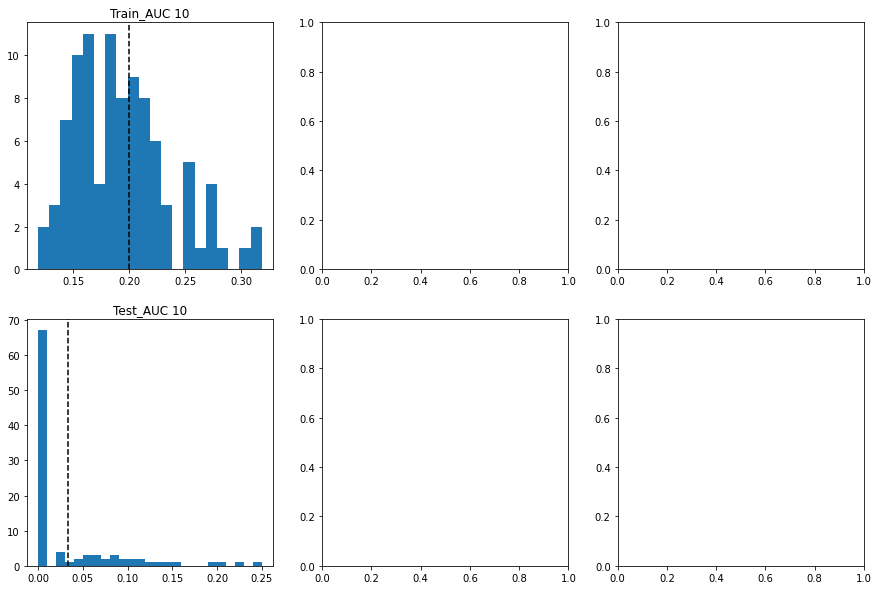

In [230]:
#len(res_f05.loc[res_f05['Percent'] == 10])
fix, ax = plt.subplots(2,3,figsize=(15,10))
bins = np.arange(0,1,0.001)
r = 0
c = 0
for s in ['Train_AUC','Test_AUC']:
    for i in [10]:
        #print(hist(res_f05.loc[res_f05['Percent'] == i][s])
        ax[r,c].hist(res_f05.loc[res_f05['Percent'] == i][s],np.arange(res_f05.loc[res_f05['Percent'] == i][s].min(),res_f05.loc[res_f05['Percent'] == i][s].max(),0.01))
        ax[r,c].axvline(res_f05.loc[res_f05['Percent'] == i][s].mean(), color='k',linestyle='dashed')
        ax[r,c].set_title(s + ' ' + str(i))
        c = c + 1
    r = r + 1
    c = 0


# Pregledovanje investiranja portfelija --> trgovanje, primerjamo z buy and hold
# Primerjava dveh strategij

In [231]:
def combined_filter_strategy(solution,start_date,df,n_lagged = 20):
        #47 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]

        #n_lagged tells us how much history we need prior to the investment
        start_buffer = start_date - datetime.timedelta(days=n_lagged)

        ####TRANSLATE TO POS ARGS####
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################
        print(solution)
        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1


        test = df.loc[df["date"]>start_buffer]

        ############QUERY SPEED TEST##############
        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()

        u0 = ' | ' if solution[36] else ' & '
        u1 = ' | ' if solution[37] else ' & '
        u2 = ' | ' if solution[38] else ' & '
        u3 = ' | ' if solution[39] else ' & '
        u4 = ' | ' if solution[40] else ' & '

        connec = ' | ' if solution[-1] else ' & '

        d0 = ' | ' if solution[41] else ' & '
        d1 = ' | ' if solution[42] else ' & '
        d2 = ' | ' if solution[43] else ' & '
        d3 = ' | ' if solution[44] else ' & '
        d4 = ' | ' if solution[45] else ' & '
        q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
            '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
            '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
            '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
            '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
            '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
            connec +
            '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
            '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
            '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
            '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
            '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
            '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')


        print(len(test))
        up = test.query(q).index
        #res = np.array([False]*len(test))
        #res[up] =True

        #returns pivot points so points where price supposedly took a turn
        return up

In [232]:
#testing function above
combined_filter_strategy(res.loc[(res["Ticker"] == "AABA") & (res["Percent"] == 10)]['Train_solution'].iloc[0],ticker400_data['AABA'].iloc[int(len(ticker400_data)/4*3)].date,ticker400_data['AABA'],n_lagged = 20)

[-0.0247 1.0582 2.0875 0.7048 3.5728 0.8289 -0.0714 4.8204 6.5982 4.0936
 -0.6009 7.1846 0 10 9 1 19 10 1 19 8 6 19 16 3 2 4 2 2 1 0 3 5 0 2 5 1 1
 1 0 1 0 0 0 0 0 1]
5570


Int64Index([  19,   21,   22,   23,   24,   25,   26,   29,   30,   32,
            ...
            5550, 5551, 5553, 5554, 5556, 5563, 5564, 5565, 5568, 5569], dtype='int64', length=1493)

[0.1513 1.882 1.0704 3.5422 -0.0601 0.2397 4.7942 5.7288 1.4677 2.1473
 2.984 3.078 10 15 10 11 0 1 19 0 16 16 15 14 2 1 4 3 2 1 2 1 3 1 3 3 1 1
 1 1 1 1 1 0 1 0 0]
9445
[0.2471 7.1497 1.7269 3.6095 7.0159 2.4145 -0.8211 7.5804 6.207 5.3462
 6.5441 1.6406 5 13 0 11 8 0 7 7 12 9 9 7 1 3 0 1 0 1 2 2 5 2 5 1 1 1 1 1
 1 0 1 1 0 1 0]
9445
Int64Index([11, 50, 51, 87, 332, 366, 469, 476, 651, 653, 783, 858, 1062, 1268, 1428, 1983, 2211, 2212, 2428, 2682, 2742, 2888, 2994, 3057, 3094, 3131, 3184, 3377, 3504, 3506, 3668, 3880, 3944, 4009, 4011, 4056, 4068, 4147, 4151, 4157, 4159, 4195, 4251, 4377, 4383, 4446, 4571, 4628, 4629, 4949, 4952, 5012, 5369, 5577, 5585, 5587, 5800, 5828, 5890, 6079, 6142, 6205, 9050], dtype='int64')


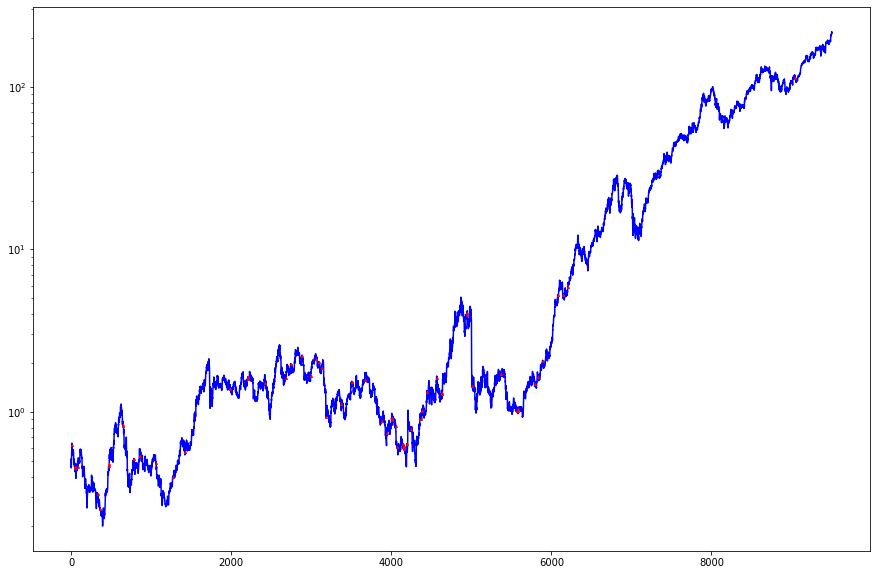

0.5296097612285684


In [236]:
def visualize_pivot_points(pivots,stock):
    plt.plot(range(len(stock.open)),stock.open,color='b',zorder=0)
    for pivot,marker,color in pivots:
        plt.scatter(pivot,stock.open.iloc[pivot],marker=marker,color=color,s=4,zorder=1)
    plt.yscale('log')
    plt.show()

ticker = "AAPL"
#20 percent is too much
percent = 10
pivots = combined_filter_strategy(res.loc[(res["Ticker"] == ticker) & (res["Percent"] == percent)]['Train_solution'].iloc[0],ticker400_data[ticker].iloc[int(len(ticker400_data)/4*3)].date,ticker400_data[ticker],n_lagged = 20)
pivots2 = combined_filter_strategy(res_f05.loc[(res_f05["Ticker"] == ticker) & (res_f05["Percent"] == percent)]['Train_solution'].iloc[0],ticker400_data[ticker].iloc[int(len(ticker400_data)/4*3)].date,ticker400_data[ticker],n_lagged = 20)
#pivots=ticker400_trend10["AAPL"]
stock = ticker400_data[ticker]
print(pivots2)
visualize_pivot_points([(pivots2,'^','r')],stock)
print(len(pivots)/len(stock))

In [195]:
# TODO: I should also try to consolidate pivots that are really close -> invest on the first one
# -> option to achieve that is to cluster until distance between closes pivots is long enough

# trend returns +1 if positive trend or -1 if negative trend
def pivots_to_trend(pivot_lower: int, pivot_higher: int, stock: pd.Series) -> int:
    """
    Defines the trend between pivot points.

    :param pivot_lower: start of interval
    :param pivot_higher: end of interval
    :param stock: stock open price history on which to check for trend
    :return: 1 if positive trend -1 if negative trend
    """
    direction = stock.iloc[pivot_higher] - stock.iloc[pivot_lower]
    print(direction, stock.iloc[pivot_lower : pivot_higher+1],stock.iloc[pivot_lower : pivot_higher+1].max(),stock.iloc[pivot_lower : pivot_higher+1].min())
    return int(direction/direction)

# return profit, lowest and highest point between pivots
def investment_extremes(pivot_lower: int, pivot_higher: int, stock: pd.Series) -> tuple[float, float, float]:
    """
    Calculate gain, overhead, drawdown in the interval of the investment for a stock.
    
    :param pivot_lower: start of interval
    :param pivot_higher: end of interval
    :param stock: stocks open price history on which to search
    :return: (gain, max_gain, max_drawdown) all measured from start fo investment
    """
    interval = stock.iloc[pivot_lower:pivot_higher+1]
    return (interval.iloc[-1]-interval.iloc[0])/interval.iloc[0],(interval.max()-interval.iloc[0])/interval.iloc[0],(interval.min()-interval.iloc[0])/interval.iloc[0]

#
def bisect_insert(l: list, insert_me: object, get_key_func: Mapping[object, int] = None) -> list:
    """
    Sorted insert with bisection

    :param l: list that we wish to insert into
    :param insert_me: variable that we wish to insert
    :param get_key_func: function to get the key for comparison(we aren't using this tbh)
    :return: ordered list with insert_me inserted
    """
    lower = 0
    upper = len(l)

    if get_key_func is not None:
        while lower < upper:
            mid_point = (lower + upper)//2
            if get_key_func(insert_me) < l[mid_point]:
                upper = mid_point
            else:
                lower = mid_point + 1
    else:
        while lower < upper:
            mid_point = (lower + upper)//2
            if insert_me < l[mid_point]:
                upper = mid_point
            else:
                lower = mid_point + 1
    l.insert(lower, insert_me)
    return l

#bisect_ticker(t, tickers_ordered, trade_iterators)
#
def bisect_ticker(ticker: str, tickers: list, ticker_trades: Dict[str, List[object]]) -> list:
    """
    Sorted insertion for tickers mapped to their trades, tickers is sorted list of tickers by start fo investment.

    :param ticker: ticker to be inserted into ordered tickers
    :param tickers: ordered list of tickers
    :param ticker_trades: dictionary of first trade of each ticker avalible
    :return: tickers with ticker inserted on the right position
    """
    lower = 0
    upper = len(tickers)

    #print("Yep1:",ticker)
    while lower < upper:
        mid_point = (lower + upper)//2
        #print("Yep2:",tickers[mid_point])
        #print("Yep2:",ticker_trades[ticker])
        if ticker_trades[ticker][0][0] < ticker_trades[tickers[mid_point]][0][0]:
            upper = mid_point
        else:
            lower = mid_point + 1

    tickers.insert(lower, ticker)
    return tickers

# get longest history of any ticker
def max_history_ticker(tickers: pd.DataFrame) -> str:
    """
    Finds the ticker with the most history
    :param tickers: dict of tickers ohlc price history
    :return: string name of
    """
    max_len = 0
    best_ticker = ""
    for t in tickers:
        if len(tickers[t]) > max_len:
            best_ticker = t
            max_len = len(tickers[t])
    return best_ticker

# investment for stock
def investment_based_on_pivots(percent: float, stock: pd.DataFrame, pivots: list, pivots_computed: list, ticker: str) -> Dict[tuple[int, int], tuple[float, float, float]]:#,play_both = False):
    """
    Calculates all trades taken using pivots.

    :param percent: percent for trend shift in fraction
    :param stock: stock historical prices ohlc
    :param pivots: model given pivots
    :param pivots_computed: algorithmically computed pivots
    :param ticker: name of ticker
    :return: (beginning_of_investment, end_of_investment) : (profit, drawdown, overhead)
    """
    opens = stock.open
    p_p_lower = 0
    p_p_higher = 0

    # [0] is beginning of investment, [1] is end of investment
    cur_investment = (-1,-1)
    # holds all past investments in format ((beginning_of_investment, end_of_investment) : (profit, drawdown, overhead))
    # we want to preserve the order in which the elements are inserted
    investments = OrderedDict()

    for c_p in pivots:
        #print(c_p,pivots_computed[p_p_lower], pivots_computed[p_p_higher])
        # we have to move the investing interval
        if c_p > pivots_computed[p_p_higher]:

            # assure p_p > c_p
            p_p_lower = p_p_higher
            for p_p_higher in range(p_p_higher,len(pivots_computed)):
                if pivots_computed[p_p_higher] >c_p or p_p_higher == len(pivots_computed):
                    break
                p_p_lower = p_p_higher
            trend = pivots_to_trend(pivots_computed[p_p_lower], pivots_computed[p_p_higher], opens)
            # the final trend
            if c_p > pivots_computed[p_p_higher] and p_p_higher == len(pivots_computed):
                print("end2")
                # we are at the end -> need to implement what to do
                trend = pivots_to_trend(pivots_computed[p_p_lower], pivots_computed[p_p_higher], opens)
                if abs(pivots_computed[p_p_lower] - pivots[c_p]) /pivots_computed[p_p_lower] < percent:
                    trend = -trend
            # we are in a downtrend, we are looking to invest
                if trend == -1:
                    return investments

                # we are in an uptrend, we are looking to exit
                else:
                    if cur_investment[0] != -1 and cur_investment[1] == -1:
                        investments[cur_investment[0], c_p] = investment_extremes(cur_investment[0],c_p,opens)

                return investments


        if pivots_computed[p_p_lower] <= c_p <= pivots_computed[p_p_higher]:
            #print(ticker)
            # get current trend between pivots

            # check if we have cleared percent% off the p_p_lower to actually make the switch in trend
            if abs(opens.iloc[pivots_computed[p_p_lower]] - opens.iloc[c_p]) /opens.iloc[pivots_computed[p_p_lower]] < percent:
                trend = -trend

            # we are in a downtrend, we are looking to invest
            if trend == -1:
                if cur_investment == (-1,-1):
                    #print("yay")
                    cur_investment = c_p, -1

            # we are in an uptrend, we are looking to exit
            else:

                if cur_investment[0] != -1 and cur_investment[1] == -1:
                    #print("yay")
                    investments[cur_investment[0], c_p] = investment_extremes(cur_investment[0],c_p,opens)
                    cur_investment = -1,-1

    # we have reached current date with open investment so we close it on the last day
    if cur_investment[0] != -1 and cur_investment[1] == -1:
        print("end")
        investments[cur_investment[0], len(opens)-1] = investment_extremes(cur_investment[0], len(opens-1), opens)

    return investments

# we do capital over all stocks




Testing

In [133]:
max_t = max_history_ticker(ticker400_data)
print(max_t)
date_75 = ticker400_data[max_t].iloc[int(len(ticker400_data[max_t])/4*3)].date
investment_based_on_pivots(0.1, ticker400_data['AABA'].loc[ticker400_data['AABA']["date"] > date_75], pivots['AABA'], computed_pivots['AABA'],'AABA')

ARNC


In [175]:
class StratTester:

    # increment type is datetime and represents reinvestment strategy
    def __init__(self, tickers, start_date, strategy, increment = -1, start_capital = 10000, model=None):
        self.tickers = tickers
        self.start_date = start_date
        self.strategy = strategy
        self.capital = [start_capital]
        self.capital_strategy = [start_capital]
        self.capital_buy_and_hold = [start_capital]
        self.investments_buy_and_hold = {}
        # we are not doing increments
        if increment == -1:
            self.incremental = False
        else:
            self.incremental = True
            self.increment = increment
            self.increment_start_date = self.start_date
        if strategy == "ga":
            #model holds params and function model=(params,strategy function)
            pass

    # buy and hold is either equally distributed across all investments or reinvested by a predefined increment the reinvestment is redistributed equally
    # returns the history of our returns
    def buy_and_hold(self):
        investment_per = self.capital_buy_and_hold[-1]/len(self.tickers)
        #print(investment_per)
        self.capital_buy_and_hold.append(0)
        if self.incremental:
            # end_increment is included in the calculation so the reinvestment happens on the same day!
            end_increment = self.increment_start_date + self.increment
            # edge case that end_increment is out of date scope then we just cut off the last week and return it
            if self.tickers[next(iter(self.tickers))]['date'].max() < self.increment_start_date:
                return self.capital_buy_and_hold
            for ticker in self.tickers:
                #print(self.increment_start_date, end_increment)
                increment = self.tickers[ticker].loc[(self.tickers[ticker]['date'] >= self.increment_start_date) & (self.tickers[ticker]['date'] <= end_increment)]
                #print(increment.iloc[0],increment.iloc[-1])
                if len(increment)<=1:
                    self.investments_buy_and_hold[ticker] = investment_per
                else:
                    percent_change = (increment.iloc[-1].open - increment.iloc[0].open) / increment.iloc[0].open
                    #print(percent_change, len(increment))
                    self.investments_buy_and_hold[ticker] = investment_per*percent_change + investment_per
                    #print(self.investments_buy_and_hold)
                    #print(self.investments_buy_and_hold[ticker])
                #if ticker == "MNST":
                    #print(percent_change,ticker,len(increment))
                    #print(increment.iloc[0].open,increment.iloc[-1].open)
                self.capital_buy_and_hold[-1] = self.investments_buy_and_hold[ticker] + self.capital_buy_and_hold[-1]
            self.increment_start_date = end_increment
            return self.buy_and_hold()
        else:
            max = 0
            besto = ""
            for ticker in self.tickers:
                increment = self.tickers[ticker].loc[(self.tickers[ticker]['date'] >= self.start_date)]
                percent_change = (increment.iloc[-1].open - increment.iloc[0].open) / increment.iloc[0].open
                #print(percent_change, investment_per)
                self.capital_buy_and_hold[-1] = self.capital_buy_and_hold[-1] + percent_change * investment_per + investment_per
            return self.capital_buy_and_hold

    def ga_pivot_strategy(self, pivots, computed_pivots, amount_of_capital_per = 0.01):
        trades = OrderedDict()
        trades_per_stock = {}
        curr_capital = self.capital[0]

        # populate all trades
        for t in self.tickers:
            print(t)
            trades_per_stock[t] = investment_based_on_pivots(percent = 0.1, stock =  self.tickers[t], pivots = pivots[t], pivots_computed = computed_pivots[t],ticker=t)

        # trade iterators needs the
        trade_iterators = {t : [(-1,-1), trades_per_stock[t].__iter__()] for t in trades_per_stock}


        # holds trade end date and amount gained (trade_end, stats)
        list_of_active_trades = []
        # ordered dict to keep tabs on portfolio growth, {day_index : capital, ticker, trade}
        capital_history = {}
        tickers_ordered = []
        # init the trade_iterators to show the first
        for t in list(trade_iterators):
                # if there is no latest trade, get latest trade from iterator
                if trade_iterators[t][0] == (-1,-1):
                    trade = next(trade_iterators[t][1],-1)
                    if trade == -1:
                        trade_iterators.pop(t)
                    else:
                        trade_iterators[t][0] = trade
                        tickers_ordered = bisect_ticker(t, tickers_ordered, trade_iterators)
        # go through these trades and simulate investment
        """while True:
            upcoming_ticker = tickers_ordered.pop(0)
            for trade in list_of_active_trades:
                if trade < trade_iterators[upcoming_ticker][0]:
                    capital_size[]
        """

        return trade_iterators
                # finding the most recent trade


In [182]:
# get maximum length
max_t = max_history_ticker(ticker400_data)
print(max_t)
date_75 = ticker400_data[max_t].iloc[int(len(ticker400_data[max_t])/4*3)].date


ARNC


In [183]:
with open('test_results100.pkl', 'rb') as handle:
        print("work")
        pivot_parameters = pickle.load(handle)

pivots = {t : combined_filter_strategy(pivot_parameters.loc[(pivot_parameters["Ticker"] == t) & (pivot_parameters["Percent"] == 10)]['Train_solution'].iloc[0], date_75,ticker400_data[t],n_lagged = 20) for t in ticker400_data}
computed_pivots = {t : trendReversals(ticker400_data[t].loc[ticker400_data[t]["date"]>date_75], 0.1) for t in ticker400_data}


work
[-0.0247 1.0582 2.0875 0.7048 3.5728 0.8289 -0.0714 4.8204 6.5982 4.0936
 -0.6009 7.1846 0 10 9 1 19 10 1 19 8 6 19 16 3 2 4 2 2 1 0 3 5 0 2 5 1 1
 1 0 1 0 0 0 0 0 1]
3082
[0.1513 1.882 1.0704 3.5422 -0.0601 0.2397 4.7942 5.7288 1.4677 2.1473
 2.984 3.078 10 15 10 11 0 1 19 0 16 16 15 14 2 1 4 3 2 1 2 1 3 1 3 3 1 1
 1 1 1 1 1 0 1 0 0]
3082
[3.0224 1.3593 0.9258 0.3324 0.2202 1.365 3.7282 -0.4351 -0.8948 5.3544
 6.4871 4.7646 19 8 14 5 0 6 1 1 16 0 19 0 5 4 3 4 2 1 1 3 0 4 1 5 1 1 1 1
 1 1 0 0 0 1 0]
3082
[0.0552 1.5796 1.2266 4.5493 3.5013 0.0478 0.6116 1.0049 -0.8662 7.4872
 7.1176 6.2162 0 5 2 8 10 1 3 12 17 16 10 8 3 4 5 1 2 2 5 2 4 3 1 0 1 1 1
 1 1 1 0 0 1 0 0]
3082
[0.0891 1.8628 0.2193 0.9075 0.0976 -0.3624 6.174 4.3486 6.2226 4.2369
 6.1642 0.0567 0 11 1 18 1 13 11 13 6 14 3 6 3 3 2 5 0 0 0 3 2 2 3 1 1 1 1
 0 1 1 1 0 0 0 0]
3082
[-0.0355 2.251 0.2153 2.5323 1.9954 3.5583 6.989 3.3491 6.9099 1.1599
 4.823 0.1666 0 12 1 10 19 3 13 3 8 5 9 18 2 5 1 1 2 5 3 5 0 3 2 1 1 1 0 0
 1

In [196]:
#ticker400_data['AABA'].iloc[int(len(ticker400_data)/4*3)].date
test = StratTester(ticker400_data,date_75,strategy=None,increment=datetime.timedelta(weeks=1))
#test2 = StratTester(ticker400_data,ticker400_data['AABA'].iloc[int(len(ticker400_data)/4*3)].date,strategy=None,increment=-1)
#print(test.buy_and_hold(),test2.buy_and_hold())
hodl = test.ga_pivot_strategy(pivots,computed_pivots)

AABA
-0.39583331346511796 22    1.281
23    1.250
24    1.240
25    1.260
26    1.250
27    1.208
28    1.167
29    1.146
30    1.229
31    1.219
32    1.198
33    1.146
34    1.198
35    1.156
36    1.135
37    1.146
38    1.188
39    1.135
40    1.120
41    1.089
42    1.073
43    1.073
44    1.031
45    1.031
46    0.906
47    0.875
48    0.875
49    0.927
50    0.927
51    0.906
52    0.896
53    0.885
Name: open, dtype: float64 1.28125 0.875
-0.17708337306976407 53    0.885
54    0.812
55    0.854
56    0.927
57    0.906
58    0.833
59    0.833
60    0.812
61    0.781
62    0.667
63    0.708
64    0.750
65    0.740
66    0.755
67    0.812
68    0.828
69    0.792
70    0.729
71    0.677
72    0.656
73    0.677
74    0.677
75    0.677
76    0.708
77    0.750
78    0.771
79    0.792
80    0.802
81    0.745
82    0.750
83    0.724
84    0.729
85    0.708
Name: open, dtype: float64 0.927083313465118 0.65625
0.10416668653488204 85     0.708
86     0.839
87     0.849
88     0.812
89     

/tmp/ipykernel_48431/3163724241.py:16: RuntimeWarning: invalid value encountered in double_scalars
  return int(direction/direction)


ValueError: cannot convert float NaN to integer

Analysis of the distribution per percent and withing ticker

In [41]:
list(res.iloc[0]["Train_solution"])

[-0.0247,
 1.0582,
 2.0875,
 0.7048,
 3.5728,
 0.8289,
 -0.0714,
 4.8204,
 6.5982,
 4.0936,
 -0.6009,
 7.1846,
 0,
 10,
 9,
 1,
 19,
 10,
 1,
 19,
 8,
 6,
 19,
 16,
 3,
 2,
 4,
 2,
 2,
 1,
 0,
 3,
 5,
 0,
 2,
 5,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1]

In [42]:
def get_triggers(df,dfY,tick,percent,n_lagged = 20,sty=0):
    def fita(solution, index):
        #47 genov
        #solution = [retUP,volUP,vol5UP,vol10UP,vol15UP,vol20UP,retDW,volDW,vol5DW,vol10DW,vol15DW,vol20DW,priorRUp,priorVUp,priorvol5UP,priorvol10UP,priorvol15UP,priorvol20UP,priorRDW,priorVDW,priorvol5DW,priorvol10DW,priorvol15DW,priorvol20DW,posR,pos1,pos5,pos10,pos15,pos20,posRD,pos1D,pos5D,pos10D,pos15D,pos20D,con1,con2,con3,con4,con5,cond1,cond2,cond3,cond4,cond5,skupi]

        ####TRANSLATE TO POS ARGS####
        posu = [-1]*6
        posd = [-1]*6
        start = 0
        for i in solution[24:30]:
            if i not in posu:
                posu[start] = i
            start = start + 1
        start = 0
        for i in solution[30:36]:
            if i not in posd:
                posd[start] = i
            start = start + 1
        start = 0
        last = 0
        for i in posu:
            if i == -1:
                for last in range(last,6):
                    if last not in posu:
                        posu[start] = last
                        break
            start = start + 1
        start = 0
        last = 0
        for i in posd:
            if i == -1:
                for last in range(last,6):
                    if last not in posd:
                        posd[start] = last
                        break
            start = start + 1

        #############################

        for ite in range(len(solution)):
            if ite<12 and solution[ite] <= -1:
                return -1
            elif ite>=12 and solution[ite] < 0:
                return -1
        solution = [x[0] if hasattr(x,'__len__') else x for x in solution]
        #print(solution)
        col = 'volume%'
        if n_lagged == 5:
            col = 'volume5%'
        if n_lagged == 10:
            col = 'volume10%'
        if n_lagged == 15:
            col = 'volume15%'
        if n_lagged == 20:
            col = 'volume20%'

        test = df[tick][1][n_lagged-1:]

        ############QUERY SPEED TEST##############
        col_names = ['return_sh','vol_sh','vol5_sh','vol10_sh','vol15_sh','vol20_sh']
        test['return_sh'] = test['return'].shift( (solution[12]))
        test['vol_sh'] = test['volume%'].shift( (solution[13]))
        test['vol5_sh'] = test['volume5%'].shift( (solution[14]))
        test['vol10_sh'] = test['volume10%'].shift( (solution[15]))
        test['vol15_sh'] = test['volume15%'].shift( (solution[16]))
        test['vol20_sh'] = test['volume20%'].shift( (solution[17]))
        test = test.reset_index()
        if sty == 0:
            u0 = ' | ' if solution[36] else ' & '
            u1 = ' | ' if solution[37] else ' & '
            u2 = ' | ' if solution[38] else ' & '
            u3 = ' | ' if solution[39] else ' & '
            u4 = ' | ' if solution[40] else ' & '

            connec = ' | ' if solution[-1] else ' & '

            d0 = ' | ' if solution[41] else ' & '
            d1 = ' | ' if solution[42] else ' & '
            d2 = ' | ' if solution[43] else ' & '
            d3 = ' | ' if solution[44] else ' & '
            d4 = ' | ' if solution[45] else ' & '
            q = ('(' +col_names[posu[0]] + ' > ' + str(solution[posu[0]]) + u0 +
                '(' +col_names[posu[1]] + ' > ' + str(solution[posu[1]]) + u1 +
                '(' +col_names[posu[2]] + ' > ' + str(solution[posu[2]]) + u2 +
                '(' +col_names[posu[3]] + ' > ' + str(solution[posu[3]]) + u3 +
                '(' +col_names[posu[4]] + ' > ' + str(solution[posu[4]]) + u4 +
                '(' +col_names[posu[5]] + ' > ' + str(solution[posu[5]]) + '))))))' +
                connec +
                '(' +col_names[posd[0]] + ' < ' + str(solution[posd[0]]) + d0 +
                '(' +col_names[posd[1]] + ' < ' + str(solution[posd[1]]) + d1 +
                '(' +col_names[posd[2]] + ' < ' + str(solution[posd[2]]) + d2 +
                '(' +col_names[posd[3]] + ' < ' + str(solution[posd[3]]) + d3 +
                '(' +col_names[posd[4]] + ' < ' + str(solution[posd[4]]) + d4 +
                '(' +col_names[posd[5]] + ' < ' + str(solution[posd[5]]) + '))))))')

            up = test.query(q).index
            res = np.array([False]*len(df[tick][1][n_lagged-1:]))
            res[up] =True


        #print(roc_auc_score(dfY[tick][percent][0],res))
        return roc_auc_score(dfY[tick][percent][1][n_lagged-1:],res)
    return fita

opcije za portofiljo managment:
-pogledamo kakšna je bla smer pred signalom in investiramo če je bla navzdol al pa

In [43]:
solid_results = pd.DataFrame(columns=['ticker','percent','train_AUC','test_AUC'])
for t in res:
    for p in res[t]:
        solid_results = solid_results.append({'ticker':t,'percent':p,'train_AUC':res[t][p]['train'].last_generation_fitness,'test_AUC':res[t][p]['test']},ignore_index=True)

KeyError: 'AABA'

In [ ]:
res['AABA'][10]["train"].save("./modeli/AABA10")

In [ ]:
print(res['AABA'][10]["train"].best_solutions[-1])

from pathlib import Path
Path("./modeli").mkdir(parents=True, exist_ok=True)
for t in res:
    for p in res[t]:
        path = Path(f"./modeli/{t}{str(p)}")
        if res[t][p]["test"] is not None and Path


Visualise reuslts

In [ ]:
#rabmo 2 subplota enga za train AUC in enga za test AUC in za razilčne procente AUC
results_for_x = [(res[t]['train'].best_solutions_fitness[-1],res[t]['test']) for t in list(ticker400_data)]